In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from abc import ABC, abstractmethod
from typing import List, Set

In [2]:
class Image:

    def __init__(
        self,
        image: np.array,
        bnd_boxes: List[Set[float]]
    ) -> None:

        self.image = image
        self.bnd_boxes = bnd_boxes

    def get_car(
        self,
        bnd_box
    ) -> np.array:
    # return cropped bounding box
    # allows to crop rotated bnd boxes

        img = self.image
        cnt = np.array([
                [[bnd_box[4], bnd_box[5]]],
                [[bnd_box[0], bnd_box[1]]],
                [[bnd_box[2], bnd_box[3]]],
                [[bnd_box[6], bnd_box[7]]]
            ])

        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        width = int(rect[1][0])
        height = int(rect[1][1])

        src_pts = box.astype("float32")
        dst_pts = np.array([[0, height-1],
                            [0, 0],
                            [width-1, 0],
                            [width-1, height-1]], dtype="float32")

        M = cv2.getPerspectiveTransform(src_pts, dst_pts)

        warped = cv2.warpPerspective(img, M, (width, height))

        return warped

In [3]:
class ImageLoader(ABC):

    def __init__(self):
        pass

    def load_image(
        self,
        image_dir: str,
        annotation_dir: str
    ) -> None:

        image: np.array = cv2.imread(image_dir)
        with open(annotation_dir, 'r') as f:
            annotation_file: str = f.read()
            bnd_boxes = self.read_bnd_boxes(annotation_file, image)
        
        return Image(image, bnd_boxes)

    @abstractmethod
    def read_bnd_boxes(
        self,
        annotation_file: str,
        image: np.array
    ) -> List[Set[float]]:
        # returns list of sets with bnd boxes coords
        # (top_left_x, top_left_y, top_right_x, top_right_y
        # bottom_left_x, bottom_left_y, bottom_right_x, bottom_right_y)
        pass

Każdy zbiór ze względu na różnicę w strukturach plików z anotacjami będzie potrzebował własną implementację klasy ImageLoader. Poniżej implementacja dla zbioru AerialCars i przykład użycia.

In [4]:
class AerialCarsImageLoader(ImageLoader):

    def read_bnd_boxes(
        self,
        annotation_file: str,
        image: np.array
    ) -> List[Set[float]]:

        annotations = []

        for ann_row in annotation_file.split('\n'):
            ann_row = ann_row.split(' ')

            if ann_row[0] == '0':
                # TODO consider other classes
            
                xc = int(image.shape[1] * float(ann_row[1]))
                yc = int(image.shape[0] * float(ann_row[2]))
                w = int(image.shape[0] * float(ann_row[3]))
                h = int(image.shape[1] * float(ann_row[4]))

                top_left_x = xc - int(w/2)
                top_left_y = yc + int(h/2)

                top_right_x = xc + int(w/2)
                top_right_y = yc + int(h/2)

                bottom_left_x = xc - int(w/2)
                bottom_left_y = yc - int(h/2)

                bottom_right_x = xc + int(w/2)
                bottom_right_y = yc - int(h/2)

                annotations.append((
                    top_left_x, top_left_y,
                    top_right_x, top_right_y,
                    bottom_left_x, bottom_left_y,
                    bottom_right_x, bottom_right_y))

        return annotations

In [5]:
aerialCarsImageLoader = AerialCarsImageLoader()

image = aerialCarsImageLoader.load_image(
    '../../data/raw/aerial-cars-dataset/MOS75.png',
    '../../data/raw/aerial-cars-dataset/MOS75.txt'
)

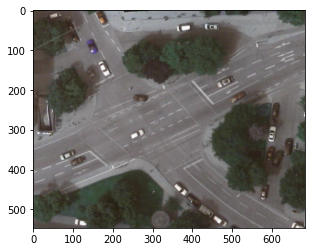

In [6]:
plt.imshow(image.image)

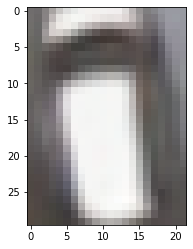

In [7]:
plt.imshow(image.get_car(image.bnd_boxes[12]))